##  Design considerations:

- We're after an approach that employs causal inference in a useful way.
- We want this to run for any choice of intervention and outcome variable. Difficulties: data missingness, uneven time overlap between time series, different spacing between data collection times, sometimes uneven spacing within a given time series
- we want to be able to train the models and pass whatever is needed to the frontend; data prep and model training for a given query takes around 2 mins on my laptop, way too much to be used online
- For this reason, preferrably store posterior samples (or even posterior sample summaries) covering multiple locations, which can be easily used to answer frontend queries
- Most time series have fairly limited time span, so it seems we cannot allow ourselves to use a separate model for each particular intervention year




### Disclaimer

Some of these moves are based on `slc.ipynb` and `sdid.ipynb` in the existing Chirho documentation. Some code is almost directly copied from these notebooks too.



### Strategy tried out in this notebook

- We use long format and year as a latent variable to predict the outcome n discrete steps later (usually, n years later) for n = 2 (possibly 1, 3, but 1 is a bit early to really see the consequences of an intervention, and 3 seems to be at the edge of where we can meaningfully reach given how short some variable time spans are). 

## Data prep given a choice of intervention and outcome variables

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition


from cities.utils.data_grabber import (DataGrabber, list_available_features, list_tensed_features)

In [2]:
def plot_predictive(model, data, intervention_variable, outcome_dataset, forward_shift, guide = None, **kwargs):

    model = condition(data=dict(**kwargs))(model)
    
    # 
    #if guide:
    #    guide_tr = pyro.poutine.trace(guide).get_trace()
    #    model_tr = pyro.poutine.trace(pyro.poutine.replay(model(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
    #                            time_index = time_index, intervention = intervention), trace=guide_tr)).get_trace()
    #else:
    with pyro.poutine.trace() as tr:
        model(**kwargs)

    model_tr = tr.trace
    y = model_tr.nodes['y']['value']

    predictive_copy = data.copy()

    predictive_copy['post_test'] = y.reshape(-1, 1).detach().numpy()  

    sns.pairplot(predictive_copy[[intervention_variable, f"{outcome_dataset}_shifted_by_{forward_shift}", 'post_test']])
    

In [3]:
#print(list_tensed_features())

In [4]:
dg = DataGrabber()

#original development settings
outcome_dataset = 'unemployment_rate' #outcome variable = its dataset name
intervention_dataset = 'spending_commerce'
intervention_variable = 'total_obligated_amount' #intervention variable
forward_shift = 2 # how many discrete steps forward we'll be trying to predict

#second tested setting
# outcome_dataset = 'gdp' #outcome variable = its dataset name
# intervention_dataset = 'spending_commerce'
# intervention_variable = 'total_obligated_amount' #intervention variable
# forward_shift = 2 # how many discrete steps forward we'll be trying to predict


#third tested setting
# outcome_dataset = 'gdp' #outcome variable = its dataset name
# intervention_dataset = 'spending_transportation'
# intervention_variable = 'total_obligated_amount' #intervention variable
# forward_shift = 1 # how many discrete steps forward we'll be trying to predict


tensed_covariates_datasets = [var for var in list_tensed_features() if var not in [outcome_dataset, intervention_dataset]]
fixed_covariates_datasets = [var for var in list_available_features() if var not in tensed_covariates_datasets + [outcome_dataset, intervention_dataset]]

# at least for now we will use only fixed covariates
# as other time series have different time spans, year missingness etc.

# morever you don't want to use time series from after the first recorded intervention
# so what we could consider doing is adding info from the time series
# for years preceding the first recorded intervention year
# but that's for later

dg.get_features_std_long(list_available_features()) 
dg.get_features_std_wide(list_available_features()) 

# we need to focus on years for which we have data on both the intervention and outcome
# for now, find the boundary years

year_min = max(dg.std_long[intervention_dataset]['Year'].min(), dg.std_long[outcome_dataset]['Year'].min())
year_max = min(dg.std_long[intervention_dataset]['Year'].max(), dg.std_long[outcome_dataset]['Year'].max())

outcome_df = dg.std_long[outcome_dataset].sort_values(by=['GeoFIPS', 'Year'])


# now we adding forward shift to the outcome
# cleaning up and puting intervention/outcome in one df
# and fixed covariates in another

outcome_df[f'{outcome_dataset}_shifted_by_{forward_shift}'] = None

geo_subsets = []
for geo_fips in outcome_df['GeoFIPS'].unique():
    geo_subset = outcome_df[outcome_df['GeoFIPS'] == geo_fips].copy()
    # Shift the 'Value' column `forward_shift` in a new column
    geo_subset[f'{outcome_dataset}_shifted_by_{forward_shift}'] = geo_subset['Value'].shift(-forward_shift)
    geo_subsets.append(geo_subset)
    
outcome_df = pd.concat(geo_subsets).reset_index(drop=True)


outcome = outcome_df[(outcome_df['Year'] >= year_min) & (outcome_df['Year'] <= year_max + forward_shift)]
intervention = dg.std_long[intervention_dataset][(dg.std_long[intervention_dataset]['Year'] >= year_min) & (dg.std_long[intervention_dataset]['Year'] <= year_max)]    
f_covariates = {dataset: dg.std_wide[dataset] for dataset in fixed_covariates_datasets}
f_covariates_joint = f_covariates[fixed_covariates_datasets[0]]
for dataset in f_covariates.keys():
    if dataset != fixed_covariates_datasets[0]:
        if 'GeoName' in f_covariates[dataset].columns:
            f_covariates[dataset] = f_covariates[dataset].drop(columns=['GeoName'])
        f_covariates_joint = f_covariates_joint.merge(f_covariates[dataset], on=['GeoFIPS'])


i_o_data = pd.merge(outcome, intervention, on=['GeoFIPS', 'Year'])

if 'GeoName_x' in i_o_data.columns:
    i_o_data.rename(columns={'GeoName_x': "GeoName"}, inplace=True)    
    columns_to_drop = i_o_data.filter(regex=r'^GeoName_[a-zA-Z]$')
    i_o_data.drop(columns=columns_to_drop.columns, inplace=True)

i_o_data.rename(columns={'Value': outcome_dataset}, inplace=True)

i_o_data['state'] = [code // 1000 for code in i_o_data['GeoFIPS']]

N_s = len(i_o_data['state'].unique())  #number of states
i_o_data.dropna(inplace=True)


i_o_data['unit_index']= pd.factorize(i_o_data['GeoFIPS'].values)[0]
i_o_data['state_index']= pd.factorize(i_o_data['state'].values)[0]
i_o_data['time_index']= pd.factorize(i_o_data['Year'].values)[0]


assert i_o_data['GeoFIPS'].isin(f_covariates_joint['GeoFIPS']).all()

f_covariates_joint.drop(columns=['GeoName'], inplace=True)
data = i_o_data.merge(f_covariates_joint, on='GeoFIPS', how='left')

assert not data.isna().any().any()

time_index_idx = data.columns.get_loc('time_index')
covariates_df = data.iloc[:, time_index_idx + 1:].copy()
covariates_df_sparse = covariates_df.copy()
covariates_df_sparse['unit_index'] = data['unit_index']
covariates_df_sparse['state_index'] = data['state_index']
covariates_df_sparse.drop_duplicates(inplace=True)
assert set(covariates_df_sparse['unit_index']) == set(data['unit_index'])

In [5]:
# get tensors for modeling

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

y = data[f'{outcome_dataset}_shifted_by_{forward_shift}']
y = torch.tensor(y, dtype=torch.float32, device = device) 

unit_index = torch.tensor(data['unit_index'], dtype=torch.int, device = device)
unit_index_sparse = torch.tensor(covariates_df_sparse['unit_index'], dtype=torch.int)

state_index = torch.tensor(data['state_index'], dtype=torch.int, device = device)
state_index_sparse = torch.tensor(covariates_df_sparse['state_index'], dtype=torch.int)

time_index = torch.tensor(data['time_index'], dtype=torch.int, device = device)
intervention = torch.tensor(data[intervention_variable], dtype=torch.float32, device = device)

covariates = torch.tensor(covariates_df.values, dtype = torch.float32, device = device)

covariates_df_sparse.drop(columns=['unit_index','state_index'], inplace=True)
covariates_sparse = torch.tensor(covariates_df_sparse.values, dtype = torch.float32, device = device)

N_cov = covariates.shape[1] #number of covariates
N_u = covariates_sparse.shape[0] #number of units (counties)
N_obs = len(y) #number of observations
N_t = len(time_index.unique()) #number of time points
N_s = len(state_index.unique()) #number of states

assert len(intervention) == len(y)
assert len(unit_index) == len(y)
assert len(state_index) == len(unit_index)
assert len(time_index) == len(unit_index)
assert covariates.shape[1] == covariates_sparse.shape[1]
assert len(unit_index_sparse) == N_u

## A naive way to estimate the causal effect of the intervention on the outcome

In [6]:
# one way to think about this
import scipy
correlation, _ = scipy.stats.pearsonr(intervention, y)
print(correlation)

# another one
# suppose we care about minimal intervention vs. well-funded places
minimal = data[data['total_obligated_amount'] < -.9]
well = data[(data['total_obligated_amount'] >= .9)]

naive_empirical_estimate = np.mean(well[f"{outcome_dataset}_shifted_by_{forward_shift}"]) - np.mean(minimal[f"{outcome_dataset}_shifted_by_{forward_shift}"])

print(naive_empirical_estimate)

# don't get too attached to the numbers themselves, they need scaling back
# into the original scale; for now keep in mind the variable values for all floats
# range between -1 and 1

-0.02249674887931928
-0.39838727829041526


## Vanilla model

We start with building a vanilla regression model that doesn't even use covariates.


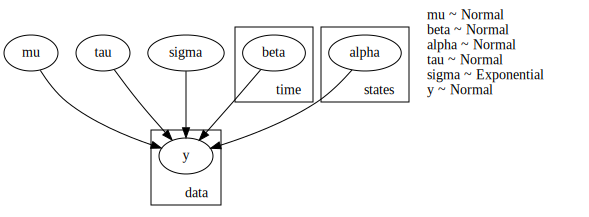

In [7]:
def cities_model_A(N_t, N_s, state_index, time_index, intervention,
                y = None):
        # Intercept 
        mu = pyro.sample("mu", dist.Normal(0, 1))

        # time effects
        with pyro.plate("time", N_t):
                beta = pyro.sample("beta", dist.Normal(0, 1))

        # state latent confounders
        with pyro.plate("states", N_s):
                alpha = pyro.sample("alpha", dist.Normal(0, 1))
        
        #treatment effect
        tau = pyro.sample("tau", dist.Normal(0, 1))

        # sd 
        sigma = pyro.sample("sigma", dist.Exponential(1))
        
        with pyro.plate("data", len(time_index)):
        
                y_mean = mu  + beta[time_index]  + alpha[state_index] + tau * intervention
                pyro.sample("y", dist.Normal(y_mean, sigma), obs = y)

        return  


pyro.render_model(cities_model_A, 
                  model_args=(N_t, N_s, state_index, time_index,
                               intervention), render_distributions=True)

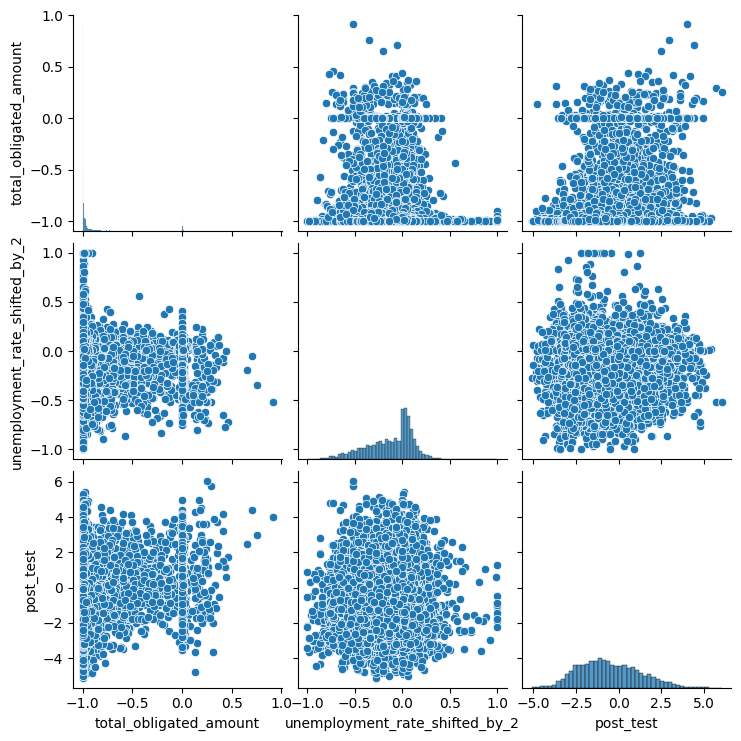

In [8]:
plot_predictive(cities_model_A, data, intervention_variable,
 outcome_dataset, forward_shift, guide=None, N_t=N_t,
  N_s=N_s, state_index=state_index, time_index=time_index,
   intervention=intervention)

[iteration 0001] loss: 1.0370
[iteration 0101] loss: 0.1149
[iteration 0201] loss: -0.1490
[iteration 0301] loss: -0.1698
[iteration 0401] loss: -0.1604
[iteration 0501] loss: -0.1762
[iteration 0601] loss: -0.1801
[iteration 0701] loss: -0.1611
[iteration 0801] loss: -0.1816
[iteration 0901] loss: -0.1754


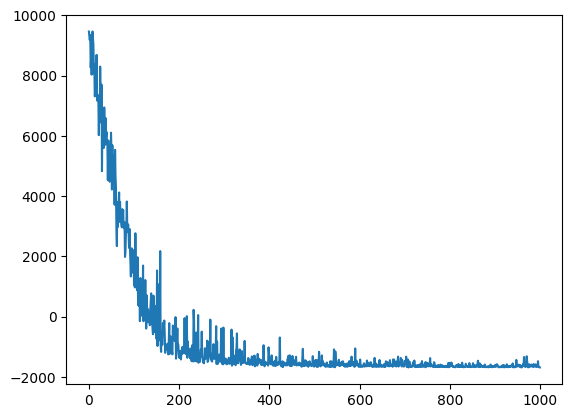

In [9]:
pyro.clear_param_store()
guide_A =  AutoNormal(cities_model_A)

# fast but much less informative
#AutoDelta(cities_model_A)

# this is painfully slow
# is there any way to make things better here?
#AutoMultivariateNormal(cities_model_A)

svi = SVI(
    model=cities_model_A,
    guide=guide_A,
    optim=Adam({"lr": 0.01}),
    loss=Trace_ELBO()  
)

losses = []
num_iterations = 1000
for step in range(num_iterations):
    # Compute the loss
    loss = svi.step(N_t, N_s, state_index, time_index, intervention, y)
    losses.append(loss)
    if step % 100 == 0:
        print('[iteration %04d] loss: %.4f' % (step + 1, loss / len(i_o_data)))

plt.plot(range(num_iterations),losses, label="Loss")
plt.show()

In [10]:
# parallel=True throws a tensor-shape-related Runtime error, why?
predictive_A = pyro.infer.Predictive(cities_model_A, guide=guide_A, num_samples=1000, parallel=False)
samples_A = predictive_A(N_t = N_t, N_s = N_s, state_index = state_index,
                                time_index = time_index, intervention = intervention)

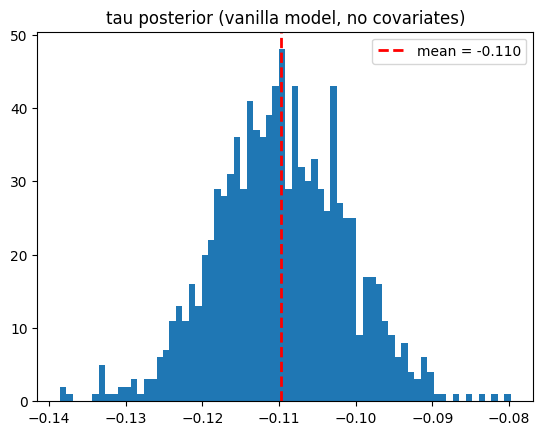

In [11]:
tau_samples = samples_A['tau'].detach().numpy()
plt.hist(tau_samples,bins = 70)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.title("tau posterior (vanilla model, no covariates)")
plt.legend()
plt.show()

In [12]:
print(samples_A['y'].shape)

torch.Size([1000, 9124])


In [13]:
def calculate_R_squared(samples, outcome_name, outcome_tensor) :
    mean_predicted_outcome = samples[outcome_name].mean(0).detach().cpu().numpy()
    observed_mean  = torch.mean(outcome_tensor)
    print("observed mean", observed_mean)

    tss = torch.sum((outcome_tensor - observed_mean) ** 2)
    rss = torch.sum((outcome_tensor - mean_predicted_outcome) ** 2)

    r_squared = 1 - (rss / tss)

    return r_squared.float().item()


calculate_R_squared(samples_A, "y", y)

observed mean tensor(-0.1214)


0.4135461449623108

### Including covariates


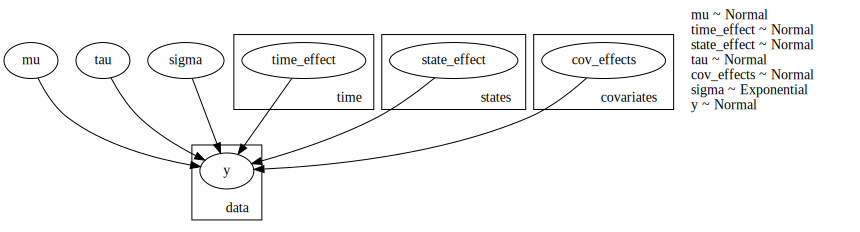

In [14]:
# like vanilla, but with covariates
# and we narrow down the priors as the posterior checked
# revealed too wide posterior


def cities_model_B(N_t, N_s, state_index, time_index,
                    intervention, covariates,
                y = None):
        # Intercept 
        mu = pyro.sample("mu", dist.Normal(0, .9))

        # time effects
        with pyro.plate("time", N_t):
                time_effect = pyro.sample("time_effect", dist.Normal(0, .9))

        # state latent confounders
        with pyro.plate("states", N_s):
                state_effect = pyro.sample("state_effect", dist.Normal(0, .9))
        
        #treatment effect
        tau = pyro.sample("tau", dist.Normal(0, .9))

        # covariate coefficients
        with pyro.plate("covariates", covariates.shape[1]):
                cov_effects = pyro.sample("cov_effects", dist.Normal(0, .8))

        # sd 
        sigma = pyro.sample("sigma", dist.Exponential(1))
        
        with pyro.plate("data", len(time_index)):
                
                y_mean = (mu  + tau * intervention + 
                    time_effect[time_index] +
                    state_effect[state_index]
                     + 
                    torch.matmul(covariates, cov_effects)
                )

                pyro.sample("y", dist.Normal(y_mean, sigma), obs = y)

        return  


cities_model_B(N_t, N_s, state_index, time_index,
                    intervention, covariates, y = y)

pyro.render_model(cities_model_B, 
                  model_args=(N_t, N_s, state_index, time_index,
                               intervention, covariates), render_distributions=True)

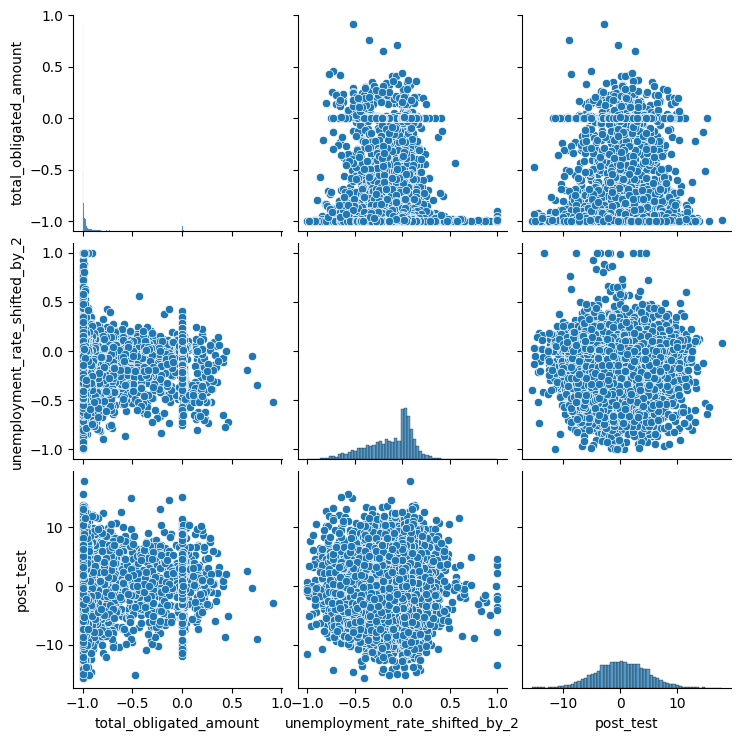

In [15]:
plot_predictive(cities_model_B, data, intervention_variable,
 outcome_dataset, forward_shift, guide=None, N_t=N_t,
  N_s=N_s, state_index=state_index, time_index=time_index,
   intervention=intervention, covariates = covariates)

[iteration 0001] loss: 1.1288
[iteration 0101] loss: 0.1865
[iteration 0201] loss: -0.0098
[iteration 0301] loss: -0.1655
[iteration 0401] loss: -0.2343
[iteration 0501] loss: -0.2704
[iteration 0601] loss: 0.0376
[iteration 0701] loss: -0.2793
[iteration 0801] loss: -0.3085
[iteration 0901] loss: -0.2778
[iteration 1001] loss: -0.3096
[iteration 1101] loss: -0.3186
[iteration 1201] loss: -0.2203
[iteration 1301] loss: -0.3166
[iteration 1401] loss: -0.3264
[iteration 1501] loss: -0.3261
[iteration 1601] loss: -0.3297
[iteration 1701] loss: -0.3008
[iteration 1801] loss: -0.3302
[iteration 1901] loss: -0.2474


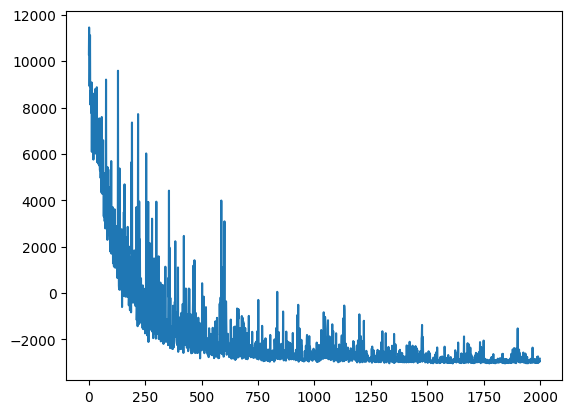

In [16]:
pyro.clear_param_store()
guide_B =  AutoNormal(cities_model_B)

svi = SVI(
    model=cities_model_B,
    guide=guide_B,
    optim=Adam({"lr": 0.01}),
    loss=Trace_ELBO()  
)

losses = []
num_iterations = 2000
for step in range(num_iterations):
    # Compute the loss
    loss = svi.step(N_t, N_s, state_index, time_index, intervention, covariates, y)
    losses.append(loss)
    if step % 100 == 0:
        print('[iteration %04d] loss: %.4f' % (step + 1, loss / len(i_o_data)))

plt.plot(range(num_iterations),losses, label="Loss")
plt.show()

In [17]:
predictive_B = pyro.infer.Predictive(cities_model_B, guide=guide_B, num_samples=1000, parallel=False)
samples_B = predictive_B(N_t = N_t, N_s = N_s, state_index = state_index,
                                time_index = time_index, intervention = intervention, covariates = covariates)

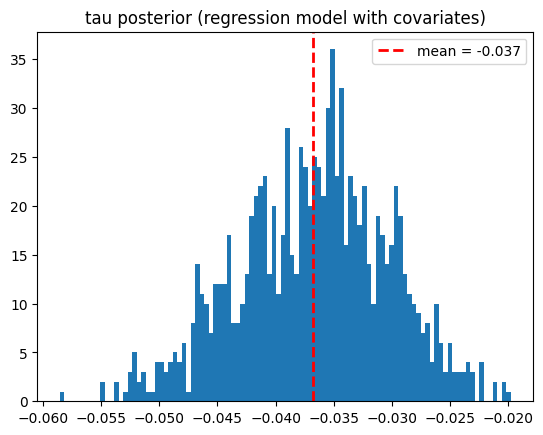

In [18]:
# already including covariates gives you a more skeptical estimate

tau_samples = samples_B['tau'].detach().numpy()
plt.hist(tau_samples,bins = 100)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.title("tau posterior (regression model with covariates)")
plt.legend()
plt.show()

In [19]:
calculate_R_squared(samples_B, "y", y)

observed mean tensor(-0.1214)


0.5771377682685852

### Latent confounders have impact on intervention

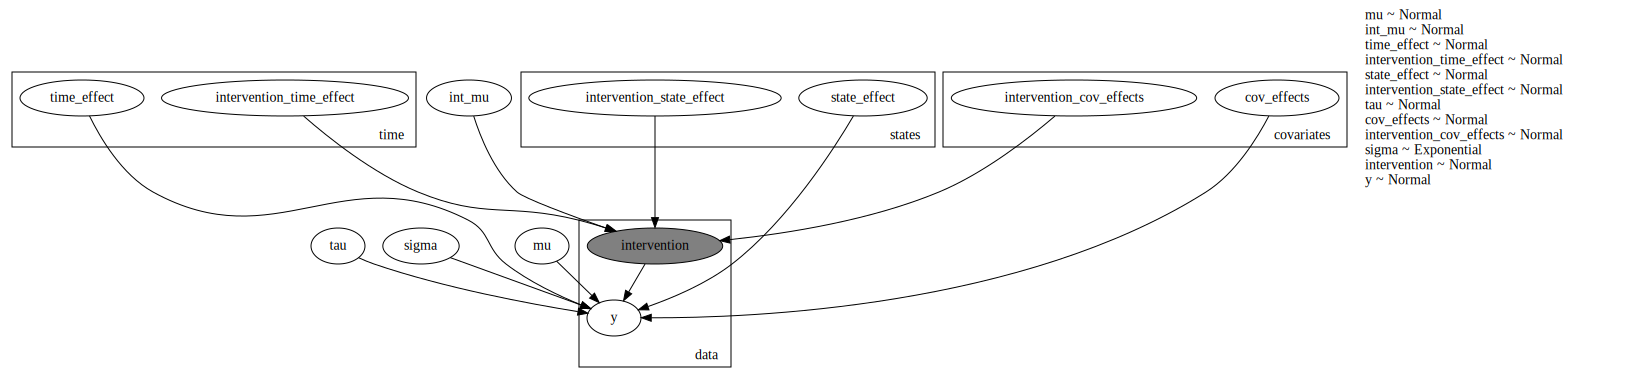

In [20]:
# like model B, but now treatment is a function
# of time effects, state effects, and covariates

def cities_model_C(N_t, N_s, state_index, time_index,
                    intervention, covariates,
                y = None):
        # Intercept 
        mu = pyro.sample("mu", dist.Normal(0, .9))
        intervention_mu = pyro.sample("int_mu", dist.Normal(0, .9))

        # time effects
        with pyro.plate("time", N_t):
                time_effect = pyro.sample("time_effect", dist.Normal(0, .9))
                intervention_time_effect = pyro.sample("intervention_time_effect", dist.Normal(0, .9))
               
        # state latent confounders
        with pyro.plate("states", N_s):
                state_effect = pyro.sample("state_effect", dist.Normal(0, .9))
                intervention_state_effect = pyro.sample("intervention_state_effect", dist.Normal(0, .9))

        #treatment effect
        tau = pyro.sample("tau", dist.Normal(0, .9))

        # covariate coefficients
        with pyro.plate("covariates", covariates.shape[1]):
                cov_effects = pyro.sample("cov_effects", dist.Normal(0, .8))
                intervention_cov_effects = pyro.sample("intervention_cov_effects", dist.Normal(0, .8))

        # sd 
        sigma = pyro.sample("sigma", dist.Exponential(1))
        
        with pyro.plate("data", len(time_index)):
        
                # print(unit_index)
                
                intervention_mean = (intervention_mu + intervention_time_effect[time_index]
                                      + intervention_state_effect[state_index] +
                                        torch.matmul(covariates, intervention_cov_effects)
                )
                intervention = pyro.sample("intervention", dist.Normal(intervention_mean, 0.9), obs = intervention)

                y_mean = (mu  + tau * intervention + 
                    time_effect[time_index] +
                    state_effect[state_index]
                     + 
                    torch.matmul(covariates, cov_effects)
                )

                pyro.sample("y", dist.Normal(y_mean, sigma), obs = y)

        return  #y_mean, mu, beta, tau, alpha


cities_model_C(N_t, N_s, state_index, time_index,
                    intervention, covariates, y = y)

pyro.render_model(cities_model_C, 
                  model_args=(N_t, N_s, state_index, time_index,
                               intervention, covariates), render_distributions=True)

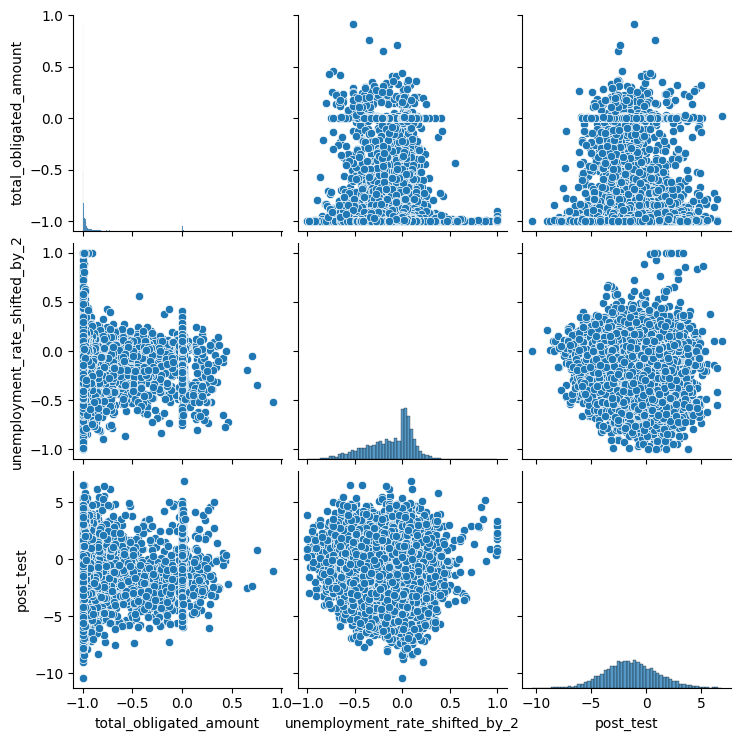

In [21]:
plot_predictive(cities_model_C, data, intervention_variable,
 outcome_dataset, forward_shift, guide=None, N_t=N_t,
  N_s=N_s, state_index=state_index, time_index=time_index,
   intervention=intervention, covariates = covariates)

[iteration 0001] loss: 2.6958
[iteration 0101] loss: 2.3645
[iteration 0201] loss: 1.2390
[iteration 0301] loss: 0.7547
[iteration 0401] loss: 0.6527
[iteration 0501] loss: 0.8074
[iteration 0601] loss: 0.5774
[iteration 0701] loss: 0.6581
[iteration 0801] loss: 0.7254
[iteration 0901] loss: 0.6859
[iteration 1001] loss: 0.5648
[iteration 1101] loss: 0.5821
[iteration 1201] loss: 0.6961
[iteration 1301] loss: 0.5733
[iteration 1401] loss: 0.6001
[iteration 1501] loss: 0.5985
[iteration 1601] loss: 0.5667
[iteration 1701] loss: 0.5905
[iteration 1801] loss: 0.5776
[iteration 1901] loss: 0.5678
[iteration 2001] loss: 0.5618
[iteration 2101] loss: 0.5895
[iteration 2201] loss: 0.6025
[iteration 2301] loss: 0.5467
[iteration 2401] loss: 0.5507


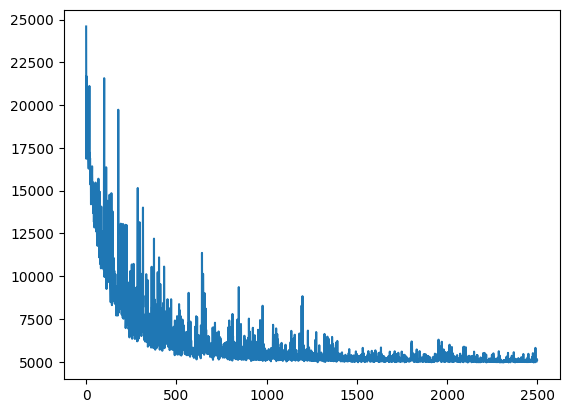

In [22]:
pyro.clear_param_store()
guide_C =  AutoNormal(cities_model_C)

svi = SVI(
    model=cities_model_C,
    guide=guide_C,
    optim=Adam({"lr": 0.01}),
    loss=Trace_ELBO()  
)

losses = []
num_iterations = 2500
for step in range(num_iterations):
    # Compute the loss
    loss = svi.step(N_t, N_s, state_index, time_index, intervention, covariates, y)
    losses.append(loss)
    if step % 100 == 0:
        print('[iteration %04d] loss: %.4f' % (step + 1, loss / len(i_o_data)))

plt.plot(range(num_iterations),losses, label="Loss")
plt.show()

In [23]:
predictive_C = pyro.infer.Predictive(cities_model_C, guide=guide_C, num_samples=1000, parallel=False)
samples_C = predictive_C(N_t= N_t, N_s = N_s, state_index = state_index,
                                time_index = time_index, intervention = intervention, covariates = covariates)

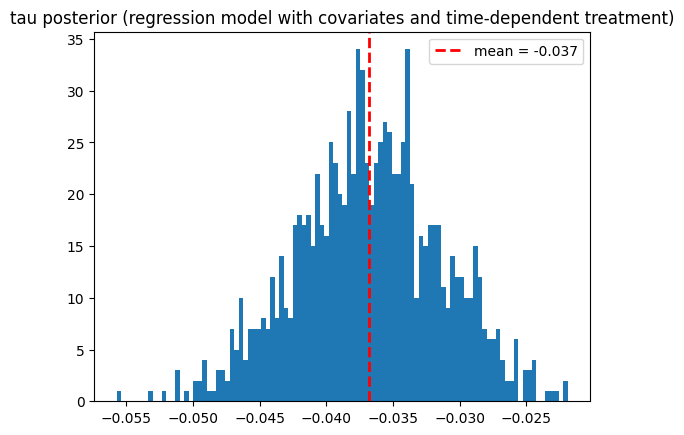

In [24]:
tau_samples = samples_C['tau'].detach().numpy()
plt.hist(tau_samples,bins = 100)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.title("tau posterior (regression model with covariates and time-dependent treatment)")
plt.legend()
plt.show()

In [25]:
calculate_R_squared(samples_C, "y", y)

observed mean tensor(-0.1214)


0.5773301124572754

### Basic confounding structure: state and time interaction

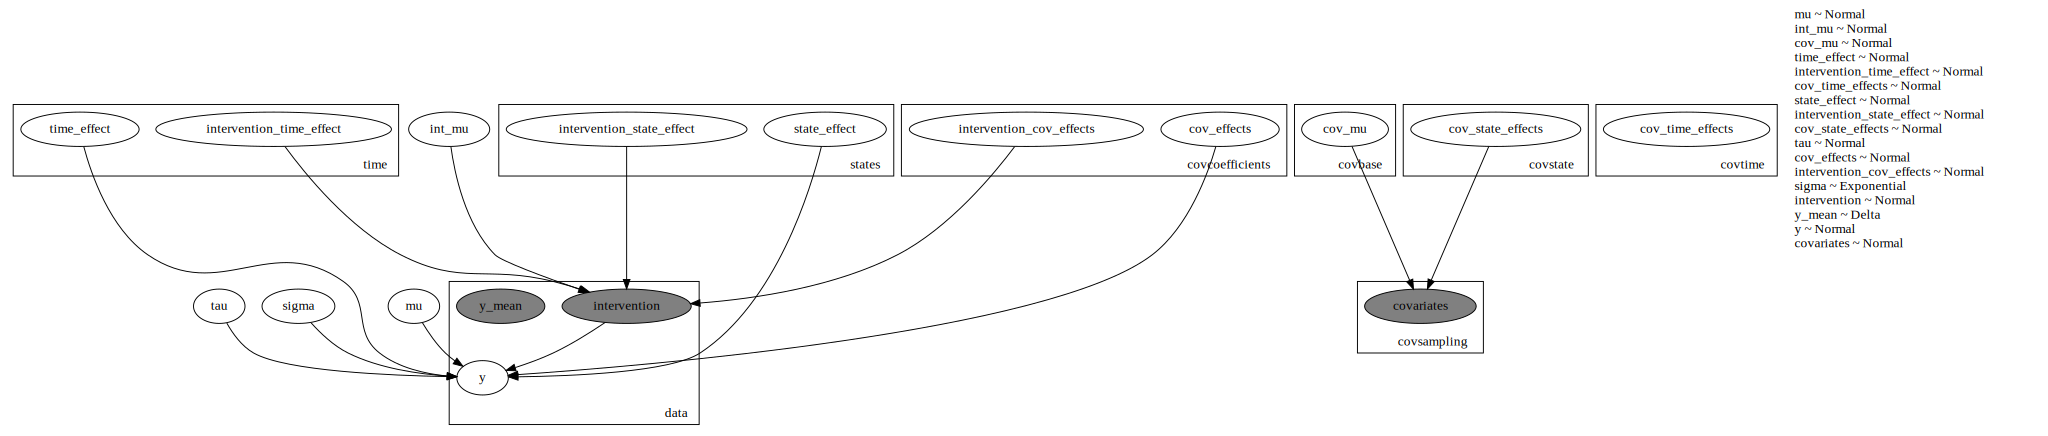

In [26]:
# like model C, but now also covariates are a function
# o state effects (makes no sense for fixed covs to be a function of time effects)

def cities_model_D(N_t, N_s, state_index, time_index,
                    intervention, covariates,
                y = None):
        
        # Intercepts
        mu = pyro.sample("mu", dist.Normal(0, .4))
        intervention_mu = pyro.sample("int_mu", dist.Normal(0, .4))

        with pyro.plate("covbase", N_cov):
                cov_mu = pyro.sample("cov_mu", dist.Normal(0, .4))
 
        # time effect
        with pyro.plate("time", N_t):
                time_effect = pyro.sample("time_effect", dist.Normal(0, .5))
                intervention_time_effect = pyro.sample("intervention_time_effect", dist.Normal(0, .5))
        
        with pyro.plate("covtime",  N_t * N_cov):
                cov_time_effects = pyro.sample("cov_time_effects",
                                                       dist.Normal(0, 0.5)).reshape(N_t, N_cov)

        # state latent confounders
        with pyro.plate("states", N_s):
                state_effect = pyro.sample("state_effect", dist.Normal(0, .5))
                intervention_state_effect = pyro.sample("intervention_state_effect", dist.Normal(0, .5))

        with pyro.plate("covstate", N_s * N_cov):
                cov_state_effects = pyro.sample("cov_state_effects",
                                                        dist.Normal(0, 0.5)).reshape(N_s, N_cov)

        #treatment effect
        tau = pyro.sample("tau", dist.Normal(0, .5))

        # covariate coefficients
        with pyro.plate("covcoefficients", N_cov):
                cov_effects = pyro.sample("cov_effects", dist.Normal(0, .5))
                intervention_cov_effects = pyro.sample("intervention_cov_effects", dist.Normal(0, .5))

        # sd 
        sigma = pyro.sample("sigma", dist.Exponential(1))
        
        with pyro.plate("data", len(time_index)):

                intervention_mean = (intervention_mu + intervention_time_effect[time_index]
                                      + intervention_state_effect[state_index] +
                                        torch.matmul(covariates, intervention_cov_effects)
                )
                intervention = pyro.sample("intervention", dist.Normal(intervention_mean, 0.5), obs = intervention)

                covariates_means = cov_mu  + cov_state_effects[state_index]

                y_mean = pyro.deterministic("y_mean", mu  + tau * intervention + 
                    time_effect[time_index] +
                    state_effect[state_index]
                     + 
                    torch.matmul(covariates, cov_effects)
                )

                pyro.sample("y", dist.Normal(y_mean, sigma), obs = y)

        with pyro.plate("covsampling", len(time_index) * N_cov):
                covariates = pyro.sample("covariates",
                        dist.Normal(covariates_means.flatten(), 0.5), 
                        obs = covariates.flatten()).reshape(len(time_index), 
                                                            N_cov)

        return  {"y_mean": y_mean, "tau": tau}


cities_model_D(N_t, N_s, state_index, time_index,
                    intervention, covariates, y = y)

pyro.render_model(cities_model_D, 
                  model_args=(N_t, N_s, state_index, time_index,
                               intervention, covariates), render_distributions=True)

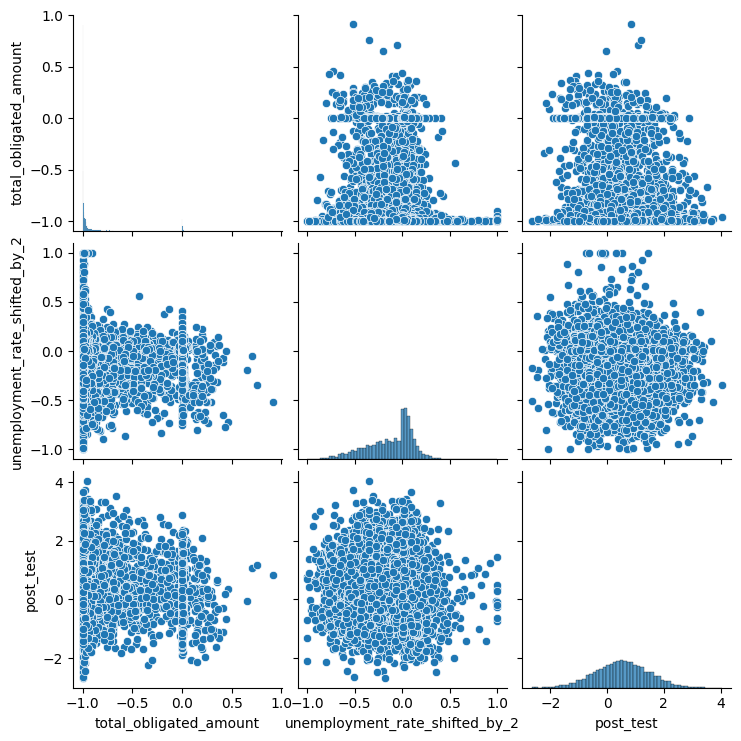

In [27]:
plot_predictive(cities_model_D, data, intervention_variable,
 outcome_dataset, forward_shift, guide=None, N_t=N_t,
  N_s=N_s, state_index=state_index, time_index=time_index,
   intervention=intervention, covariates = covariates)

[iteration 0001] loss: 23.4131
[iteration 0101] loss: 13.0148
[iteration 0201] loss: 12.4941
[iteration 0301] loss: 12.2545
[iteration 0401] loss: 12.1352
[iteration 0501] loss: 12.1464
[iteration 0601] loss: 12.0743
[iteration 0701] loss: 11.9779
[iteration 0801] loss: 11.9954
[iteration 0901] loss: 12.1382
[iteration 1001] loss: 11.9454
[iteration 1101] loss: 12.0202
[iteration 1201] loss: 11.9795
[iteration 1301] loss: 11.9433
[iteration 1401] loss: 11.9294
[iteration 1501] loss: 11.9354
[iteration 1601] loss: 11.9219
[iteration 1701] loss: 11.9339
[iteration 1801] loss: 12.0104
[iteration 1901] loss: 11.9227


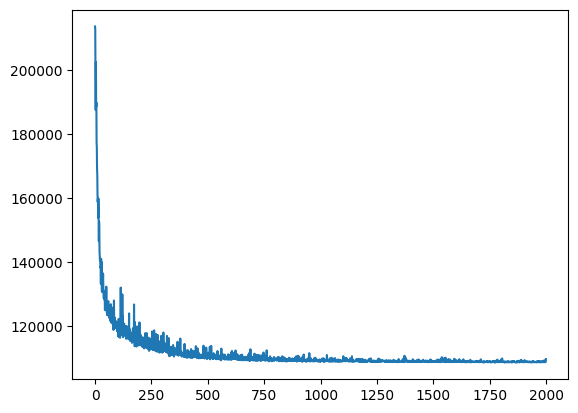

In [28]:
pyro.clear_param_store()
guide_D =  AutoNormal(cities_model_D)

svi = SVI(
    model=cities_model_D,
    guide=guide_D,
    optim=Adam({"lr": 0.01}),
    loss=Trace_ELBO()  
)


losses = []
num_iterations = 2000
for step in range(num_iterations):
    loss = svi.step(N_t, N_s, state_index, time_index, intervention, covariates, y)
    losses.append(loss)
    if step % 100 == 0:
        print('[iteration %04d] loss: %.4f' % (step + 1, loss / len(i_o_data)))

plt.plot(range(num_iterations),losses, label="Loss")
plt.show()

In [29]:
predictive_D = pyro.infer.Predictive(cities_model_D, guide=guide_D, num_samples=1000, parallel=False)
samples_D = predictive_D(N_t= N_t, N_s = N_s, state_index = state_index,
                                time_index = time_index, intervention = intervention, covariates = covariates)

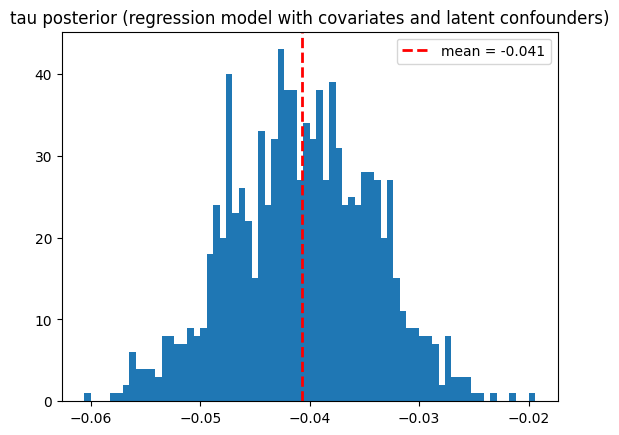

In [30]:
# estimate with covariates and latent confounders impacting covariates, intervention, and outcome
tau_samples = samples_D['tau'].detach().numpy()
plt.hist(tau_samples,bins = 70)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.title("tau posterior (regression model with covariates and latent confounders)")
plt.legend()
plt.show()

In [31]:
calculate_R_squared(samples_D, "y", y)

observed mean tensor(-0.1214)


0.5552252531051636

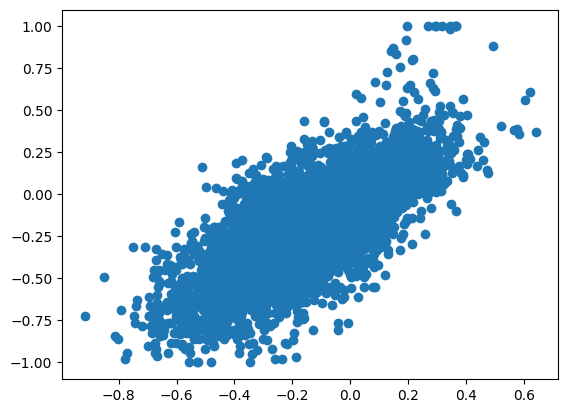

(array([  1.,   0.,   0.,   3.,   3.,   3.,   1.,   4.,   1.,   7.,   1.,
          2.,   4.,   6.,   3.,  10.,  14.,  17.,  26.,  15.,  32.,  54.,
         49.,  56.,  72., 104., 126., 167., 228., 293., 307., 409., 462.,
        540., 585., 583., 579., 542., 490., 461., 398., 369., 321., 311.,
        250., 226., 192., 148., 124., 122.,  89.,  78.,  43.,  42.,  34.,
         25.,  27.,  17.,  10.,   8.,   5.,   6.,   3.,   4.,   3.,   3.,
          0.,   2.,   2.,   2.]),
 array([-0.80328299, -0.7806713 , -0.75805961, -0.73544792, -0.71283622,
        -0.69022453, -0.66761284, -0.64500115, -0.62238946, -0.59977776,
        -0.57716607, -0.55455438, -0.53194269, -0.509331  , -0.4867193 ,
        -0.46410761, -0.44149592, -0.41888423, -0.39627254, -0.37366084,
        -0.35104915, -0.32843746, -0.30582577, -0.28321408, -0.26060239,
        -0.23799069, -0.215379  , -0.19276731, -0.17015562, -0.14754393,
        -0.12493223, -0.10232054, -0.07970885, -0.05709716, -0.03448547,
        -0.

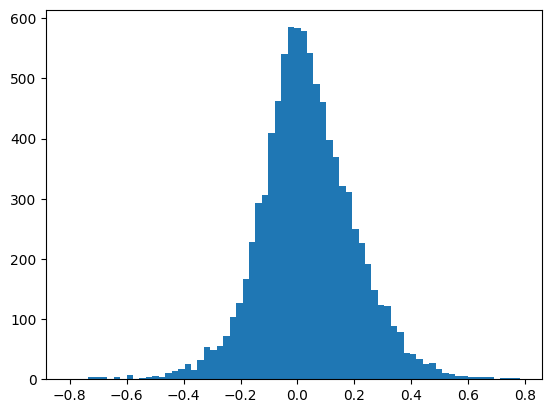

In [32]:
predicted_means_D = samples_D['y'].detach().numpy().mean(0)
plt.scatter(predicted_means_D, y.detach().numpy())
plt.show()

plt.hist(predicted_means_D - y.tolist(), bins=70)

In [51]:
#with pyro.poutine.trace() as tr_D:
with MultiWorldCounterfactual() as mwc_D:
    samples_D = predictive_D(N_t= N_t, N_s = N_s, state_index = state_index,
                            time_index = time_index, intervention = intervention, covariates = covariates)
        

In [35]:
# awfully hacky and awfully slow, but neither changing num_samples nor using plate works
num_countefactual_samples = 150

predictive_D_single = pyro.infer.Predictive(cities_model_D, guide=guide_D, 
                                            num_samples=1, return_sites=("tau", "y_mean", "y"))
with MultiWorldCounterfactual() as mwc:
    with do(actions=dict(intervention=(-0.9, .9))):
            samples_D_counterfactual = []
            for _ in range(num_countefactual_samples):
                 samples_D_counterfactual.append(predictive_D_single(N_t = N_t, N_s = N_s, 
                                                        state_index = state_index,
                                time_index = time_index, intervention = intervention, covariates = covariates))

y_means = []
ys = []
for i in range (num_countefactual_samples):
    # note gather within mwc doesn't work very nice as indices across samples have different names 
    y_means.append(samples_D_counterfactual[i]['y_mean'])
    ys.append(samples_D_counterfactual[i]['y'])      

In [36]:
y_means_low = []
y_means_high = []
ys_low = []
ys_high = []

for i in range (num_countefactual_samples):
    y_means_low.append(y_means[i].squeeze()[1].tolist())
    y_means_high.append(y_means[i].squeeze()[2].tolist())
    ys_low.append(ys[i].squeeze()[1].tolist())
    ys_high.append(ys[i].squeeze()[2].tolist())

y_means_low_df = pd.DataFrame(y_means_low).T
y_means_high_df = pd.DataFrame(y_means_high).T
ys_low_df = pd.DataFrame(ys_low).T
ys_high_df = pd.DataFrame(ys_high).T

# now the estimated average treatment effect between .9 and -.9 is around 8 times lower
display(y_means_high_df.values.mean() - y_means_low_df.values.mean())

-0.07114739279439396

### SLC generative model

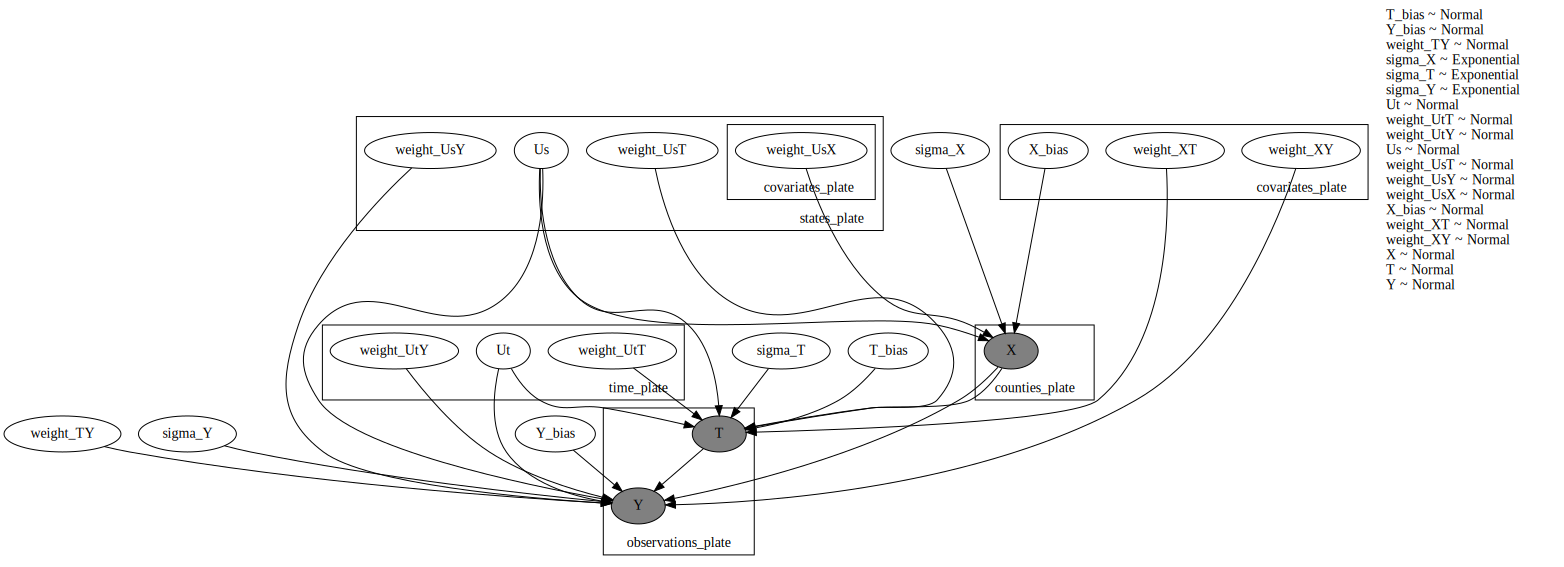

In [37]:
# TODO clean up print statements
# TODO (?) add additional latent dimensions to the confounders


leeway =.1


def cities_model_E(N_t, N_s, state_index, time_index):
    
    T_bias = pyro.sample("T_bias", dist.Normal(0, leeway))
    Y_bias = pyro.sample("Y_bias", dist.Normal(torch.mean(y), leeway))
    
    weight_TY = pyro.sample("weight_TY", dist.Normal(0, leeway))
    
    sigma_X = pyro.sample("sigma_X", dist.Exponential(1))
    sigma_T = pyro.sample("sigma_T", dist.Exponential(1))
    sigma_Y = pyro.sample("sigma_Y", dist.Exponential(1))
    
    observations_plate = pyro.plate("observations_plate", N_obs, dim = -1)
    counties_plate = pyro.plate("counties_plate", N_u, dim = -2)
    states_plate = pyro.plate("states_plate", N_s, dim=-3)
    covariates_plate = pyro.plate("covariates_plate", N_cov, dim=-4)
    time_plate = pyro.plate("time_plate", N_t, dim=-5)

    with time_plate:
        # time-related confounders
        Ut = pyro.sample("Ut", dist.Normal(0, leeway))
        
        # impact thereof on treatment
        weight_UtT = pyro.sample("weight_UtT", dist.Normal(0, leeway))
        
        # impact thereof on outcome
        weight_UtY = pyro.sample("weight_UtY", dist.Normal(0, leeway))
        
    with states_plate:
        # state-related confounders
        Us = pyro.sample("Us", dist.Normal(0, leeway))
        
        # impact thereof on treatment
        weight_UsT = pyro.sample("weight_UsT", dist.Normal(0, leeway))
        
        # impact thereof on outcome
        weight_UsY = pyro.sample("weight_UsY", dist.Normal(0, leeway))
   
        with covariates_plate:
            weight_UsX = pyro.sample("weight_UsX", dist.Normal(0, leeway))                    
            
    with covariates_plate:
        X_bias = pyro.sample("X_bias", dist.Normal(0, leeway))
        weight_XT = pyro.sample("weight_XT", dist.Normal(0, leeway))
        weight_XY = pyro.sample("weight_XY", dist.Normal(0, leeway))
        
    with counties_plate:
        # squeezing added to avoid shape errors when predictive sampling
        # as values get dimensions of size 1 (on both sides of non-trival dims)
        UsX_weighted = torch.einsum("ij...,j...->ij", weight_UsX.squeeze(), Us.squeeze())
        UsX_weighted_selected = UsX_weighted[...,state_index_sparse].squeeze()
        X_means = torch.einsum("i...,ik->ik" ,X_bias, UsX_weighted_selected)[...,unit_index_sparse].T
        X = pyro.sample("X", dist.Normal(X_means, sigma_X))
        
    with observations_plate:
      
        UtT_weighted = torch.einsum("...i,...j->...ij", weight_UtT, Ut)
     
        UsT_weighted = torch.einsum("...i,...j->...ij", weight_UsT, Us)
        
        # squeezing added to avoid shape errors when predictive sampling
        XT_weighted = torch.einsum("i...,ji->j", weight_XT.squeeze(), X.squeeze())

        # squeezing added to avoid shape errors when predictive sampling
        T_mean = (T_bias + UtT_weighted[time_index, ...].squeeze() 
                  + UsT_weighted.squeeze()[state_index, ...].squeeze()
                  + XT_weighted[unit_index])
        
        T = pyro.sample("T", dist.Normal(T_mean, sigma_T))
   
        UtY_weighted = torch.einsum("...i,...j->...ij", weight_UtY, Ut)
        UsY_weighted = torch.einsum("...i,...j->...ij", weight_UsY, Us)
        
        # squeezing added to avoid shape errors when predictive sampling
        XY_weighted = torch.einsum("i...,ji->j", weight_XY.squeeze(), X.squeeze())
        
        Y_mean = (Y_bias + UtY_weighted[time_index, ...].squeeze() +
                UsY_weighted.squeeze()[state_index, ...].squeeze() +
                weight_TY * T + XY_weighted[unit_index]
                )   
        
        Y = pyro.sample("Y", dist.Normal(Y_mean, sigma_Y))
   

with pyro.poutine.trace() as tr_e:
    cities_model_E(N_t, N_s, state_index, time_index)

# for key in tr.trace.nodes.keys():
#     if not key.endswith("_plate"):
#         print(key, tr.trace.nodes[key]["value"].shape)


assert tr_e.trace.nodes["T"]["value"].shape == intervention.shape
assert tr_e,trace.nodes["Y"]["value"].shape == y.shape
assert tr_e.trace.nodes["X"]["value"].shape == covariates_sparse.shape

cities_model_E_conditioned = pyro.condition(cities_model_E, data = {"T": intervention, "Y": y, "X": covariates_sparse})

pyro.render_model(cities_model_E_conditioned, 
                  model_args=(N_t, N_s, state_index, time_index),
                  render_distributions=True)

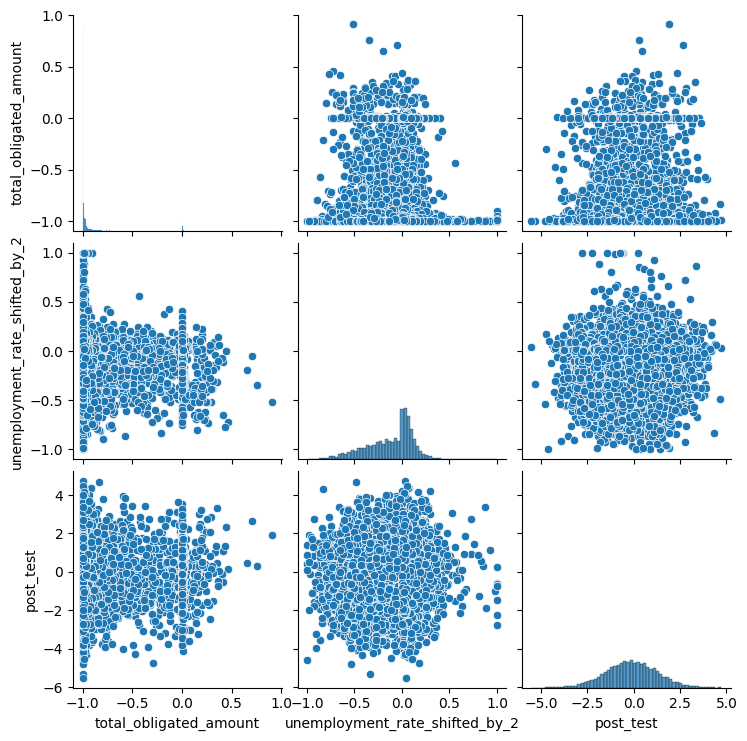

In [38]:
#TODO: double check after data transformations 

prior_Y = tr_e.trace.nodes['Y']['value']
predictive_copy = data.copy()
predictive_copy['post_test'] = prior_Y.reshape(-1, 1).detach().numpy() 
sns.pairplot(predictive_copy[[intervention_variable, f"{outcome_dataset}_shifted_by_{forward_shift}", 'post_test']]) 

[iteration 0001] loss: 14.2603
[iteration 0101] loss: 7.8627
[iteration 0201] loss: 7.4240
[iteration 0301] loss: 3.3365
[iteration 0401] loss: 3.0767
[iteration 0501] loss: 2.9010
[iteration 0601] loss: 2.7485
[iteration 0701] loss: 2.7463
[iteration 0801] loss: 2.7685
[iteration 0901] loss: 2.8140


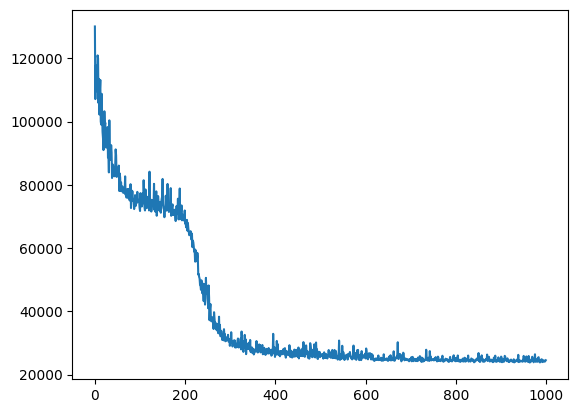

In [39]:
pyro.clear_param_store()
guide_E =  AutoNormal(cities_model_E_conditioned)

svi = SVI(
    model=cities_model_E_conditioned,
    guide=guide_E,
    optim=Adam({"lr": 0.01}),
    loss=Trace_ELBO()  
)

losses = []
num_iterations = 1000
for step in range(num_iterations):
    loss = svi.step(N_t, N_s, state_index, time_index)
    losses.append(loss)
    if step % 100 == 0:
        print('[iteration %04d] loss: %.4f' % (step + 1, loss / N_obs))

plt.plot(range(num_iterations),losses, label="Loss")
plt.show()

In [40]:
predictive_E = pyro.infer.Predictive(cities_model_E, guide=guide_E, num_samples=1000, parallel=False)

In [41]:
samples_E = predictive_E(N_t, N_s, state_index, time_index)

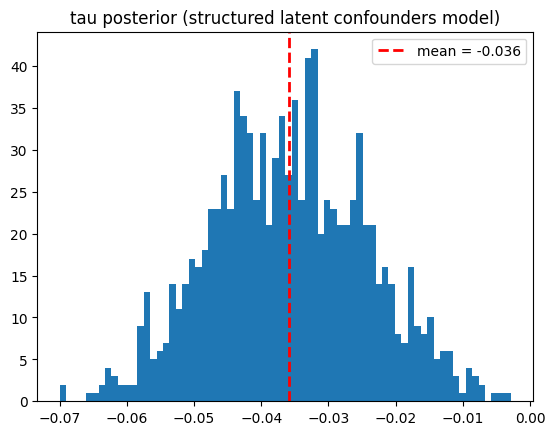

In [42]:
# estimate with covariates and latent confounders impacting covariates, intervention, and outcome
tau_samples = samples_E['weight_TY'].squeeze().detach().numpy()

plt.hist(tau_samples,bins = 70)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.title("tau posterior (structured latent confounders model)")
plt.legend()
plt.show()

dict_keys(['T_bias', 'Y_bias', 'weight_TY', 'sigma_X', 'sigma_T', 'sigma_Y', 'Ut', 'weight_UtT', 'weight_UtY', 'Us', 'weight_UsT', 'weight_UsY', 'weight_UsX', 'X_bias', 'weight_XT', 'weight_XY', 'X', 'T', 'Y'])


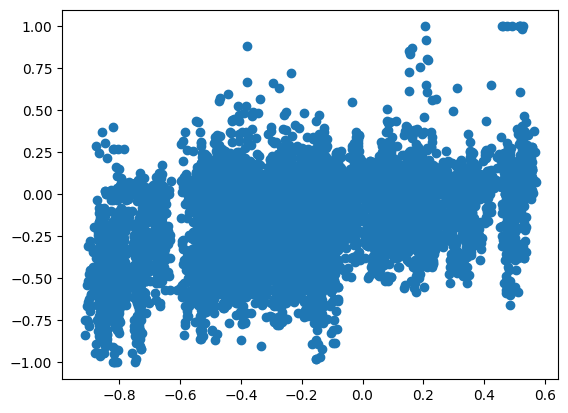

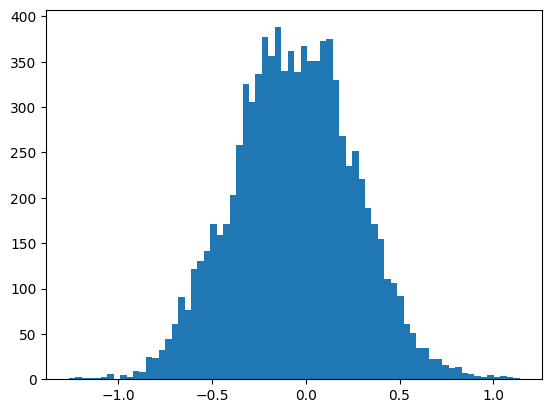

In [44]:
print(posterior_predictive_samples_E.keys())
outcome_name = "Y"

predictions = posterior_predictive_samples_E[outcome_name].squeeze().T
mean_predictions = torch.mean(predictions, dim = 1)


plt.scatter(x = mean_predictions,y =  y)
plt.show()

plt.hist(mean_predictions - y, bins=70)
plt.show()

In [45]:
observed_mean = torch.mean(y)
tss = torch.sum((y - observed_mean) ** 2)
print("tss", tss)
rss = torch.sum((y - mean_predictions) ** 2)
print("rss", rss)
r_squared = 1 - (rss / tss)
print("r_squared", r_squared)

# TODO Figure this out

tss tensor(594.6318)
rss tensor(987.0506)
r_squared tensor(-0.6599)


In [46]:
# with MultiWorldCounterfactual() as mwc:
#     with do(actions=dict(intervention=(-0.9, .9))):
#         with pyro.poutine.trace() as mwtr:
#             posterior_predictive_samples_E_counterfactual = posterior_predictive_E(N_t, N_s, state_index, time_index)
   

### Two-step forward prediction for the first SLC model


In [47]:
# summarizing the samples to be able to answer questions 
# about particular locations
def add_sample_summaries(sample_df):
    sample_df['mean'] = sample_df.mean(axis=1)
    sample_df['low'] = sample_df.quantile(0.025, axis=1)
    sample_df['high'] = sample_df.quantile(0.975, axis=1)


dfs_to_summarize = [y_means_low_df, y_means_high_df, ys_low_df, ys_high_df]
for d in dfs_to_summarize:
    add_sample_summaries(d)

display(ys_high_df.head())

,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,mean,low,high
0,-0.180574,-0.091474,-0.251693,-0.263514,-0.042316,-0.210996,-0.348071,-0.487963,-0.575194,-0.361515,...,-0.182386,-0.356006,-0.349707,-0.239002,-0.124991,-0.103041,-0.331073,-0.213469,-0.534525,0.138830
1,-0.213634,-0.430327,0.188089,-0.369003,0.058780,-0.081775,-0.156321,-0.569097,-0.252824,-0.124831,...,-0.172815,-0.241864,-0.295391,-0.281788,-0.308078,-0.137292,-0.189784,-0.253907,-0.554894,0.088614
2,-0.612148,-0.404329,-0.086261,-0.431364,-0.233474,-0.221349,-0.269544,-0.240724,-0.244156,-0.373571,...,-0.788928,-0.211388,-0.276127,-0.259337,-0.261554,-0.473377,-0.163370,-0.320091,-0.667904,-0.029591
3,-0.282474,-0.775318,-0.223591,-0.259091,-0.378664,-0.221748,-0.335763,-0.112024,-0.392602,-0.269389,...,-0.279432,0.146663,-0.430167,-0.437238,-0.504617,-0.438084,-0.476706,-0.310324,-0.633351,0.005184
4,0.123537,-0.169268,-0.565231,-0.125671,-0.064785,0.178637,-0.381153,-0.679347,-0.569701,-0.313740,...,-0.486644,-0.239656,-0.153991,0.036893,-0.309640,-0.145488,-0.293081,-0.294210,-0.632273,0.064982


,GeoFIPS,GeoName,Year,unemployment_rate,unemployment_rate_shifted_by_2,total_obligated_amount,state,unit_index,state_index,time_index,...,mexican,puerto_rican,cuban,other_hispanic_latino,white,black_african_american,american_indian_alaska_native,asian,native_hawaiian_other_pacific_islander,other_race_races
317,4005,"Coconino County, AZ",2010,0.020000,0.035354,-0.996090,4,86,2,8,...,0.032692,-0.554202,0.003765,0.029337,-0.299269,-0.841723,0.255092,0.008419,0.004459,0.060462
318,4005,"Coconino County, AZ",2011,0.038835,0.043956,-0.993462,4,86,2,1,...,0.032692,-0.554202,0.003765,0.029337,-0.299269,-0.841723,0.255092,0.008419,0.004459,0.060462
319,4005,"Coconino County, AZ",2012,0.035354,0.044444,-0.925983,4,86,2,9,...,0.032692,-0.554202,0.003765,0.029337,-0.299269,-0.841723,0.255092,0.008419,0.004459,0.060462
320,4005,"Coconino County, AZ",2013,0.043956,0.047368,-0.989051,4,86,2,2,...,0.032692,-0.554202,0.003765,0.029337,-0.299269,-0.841723,0.255092,0.008419,0.004459,0.060462
321,4005,"Coconino County, AZ",2014,0.044444,0.042328,-0.980490,4,86,2,3,...,0.032692,-0.554202,0.003765,0.029337,-0.299269,-0.841723,0.255092,0.008419,0.004459,0.060462
322,4005,"Coconino County, AZ",2015,0.047368,0.066225,-0.990365,4,86,2,4,...,0.032692,-0.554202,0.003765,0.029337,-0.299269,-0.841723,0.255092,0.008419,0.004459,0.060462
323,4005,"Coconino County, AZ",2016,0.042328,0.089041,-0.985109,4,86,2,5,...,0.032692,-0.554202,0.003765,0.029337,-0.299269,-0.841723,0.255092,0.008419,0.004459,0.060462
324,4005,"Coconino County, AZ",2017,0.066225,0.101796,-0.986606,4,86,2,0,...,0.032692,-0.554202,0.003765,0.029337,-0.299269,-0.841723,0.255092,0.008419,0.004459,0.060462
325,4005,"Coconino County, AZ",2018,0.089041,0.177215,-0.982485,4,86,2,6,...,0.032692,-0.554202,0.003765,0.029337,-0.299269,-0.841723,0.255092,0.008419,0.004459,0.060462
326,4005,"Coconino County, AZ",2019,0.101796,0.101351,-0.968296,4,86,2,7,...,0.032692,-0.554202,0.003765,0.029337,-0.299269,-0.841723,0.255092,0.008419,0.004459,0.060462


Index([323], dtype='int64')


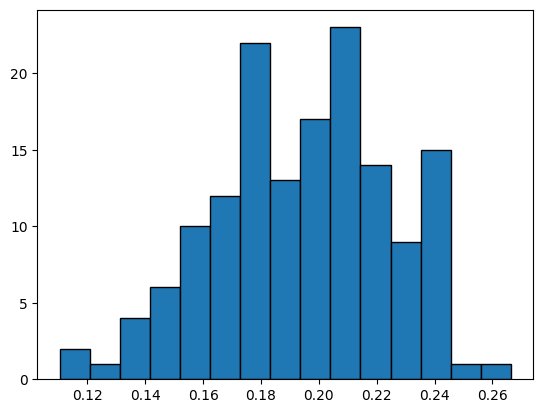

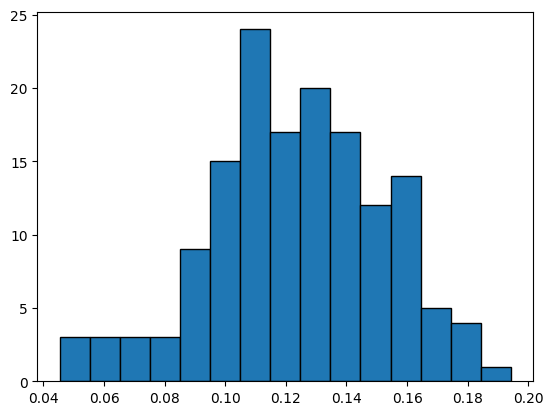

In [52]:
# now suppose I care only about a particular location

fips = 4005
year = 2016

data_fips = data[data['GeoFIPS'] == fips].copy()
display(data_fips)

row_number = data.index[(data['GeoFIPS'] == fips) & (data['Year'] == year)]
print(row_number)

unit_samples_row_low = y_means_low_df.iloc[row_number].values.tolist()[0]
unit_samples_row_high = y_means_high_df.iloc[row_number].values.tolist()[0]

# predicted unemployment rate under intervention -.9
plt.hist(unit_samples_row_low[:-3], bins=15, edgecolor='k')
plt.show()

# predicted unemployment rate under intervention .9
plt.hist(unit_samples_row_high[:-3], bins=15, edgecolor='k')
plt.show()

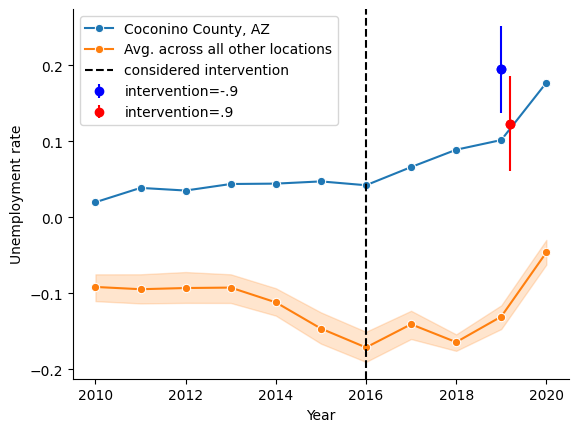

In [49]:
sns.lineplot(
    x=data_fips["Year"],
    y=data_fips[outcome_dataset],
    marker="o",
    label=data_fips['GeoName'].unique()[0],
)

# Sam's suggestion: perhaps overall mean is distracting in these plot
sns.lineplot(
    x=data[data["GeoFIPS"] != fips]["Year"],
    y=data[data["GeoFIPS"] != fips][outcome_dataset],
    marker="o",
    label='Avg. across all other locations',
)

plt.axvline(
    year, label="considered intervention", color="black", linestyle="dashed"
)


x_point = 2019
y_point_low = unit_samples_row_low[-3]
error_low = (unit_samples_row_low[-3]) -  (unit_samples_row_low[-2])

y_point_high = unit_samples_row_high[-3]
error_high = (unit_samples_row_high[-3]) -  (unit_samples_row_high[-2])


plt.scatter(
    x_point,
    y_point_low,
    color='blue',  
#    label='intervention=-.9'
)

plt.errorbar(
    x_point,
    y_point_low,
    yerr=error_low,
    fmt='o',  # Marker style for the error bar
    color='blue',  # Color of the error bar
    label='intervention=-.9',
)

plt.scatter(
    x_point + .2,
    y_point_high,
    color='red',  
#    label='intervention=-.9'
)

plt.errorbar(
    x_point + .2,
    y_point_high,
    yerr=error_high,
    fmt='o',  
    color='red',  
    label='intervention=.9',
)

plt.ylabel("Unemployment rate")
sns.despine()
plt.legend()